In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

In [4]:
# Cargar el conjunto de datos
df = pd.read_csv("./airbnb-listings-extract.csv", sep=";")

In [5]:
# Eliminar valores vacíos, nulos o letras de la columna Price
df = df[pd.to_numeric(df['Price'], errors='coerce').notnull()]
df['Price'] = df['Price'].astype(float)

In [6]:
# Dividir el conjunto de datos en entrenamiento y prueba (por ejemplo, 80-20 split)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
# a. Head, describe, dtypes
print(df.head())
print(df.describe())
print(df.dtypes)

         ID                            Listing Url       Scrape ID  \
0  11210388  https://www.airbnb.com/rooms/11210388  20170306202425   
1  17471131  https://www.airbnb.com/rooms/17471131  20170407214050   
2  17584891  https://www.airbnb.com/rooms/17584891  20170407214050   
3   5398030   https://www.airbnb.com/rooms/5398030  20170407214050   
4  18104606  https://www.airbnb.com/rooms/18104606  20170407214050   

  Last Scraped                                 Name  \
0   2017-03-07       The Loft-Full Bath-Deck w/View   
1   2017-04-08           Claris I, Friendly Rentals   
2   2017-04-08  Style Terrace Red, Friendly Rentals   
3   2017-04-08    Picasso Suite 1.4 Paseo de Gracia   
4   2017-04-08       Smart City Centre Apartment II   

                                             Summary  \
0  Loft in the Hill country 12-15 minutes directl...   
1  This apartment has: 1 double bed, 1 double sof...   
2  This apartment has: 1 double bed, 1 double sof...   
3  Live like a local in 

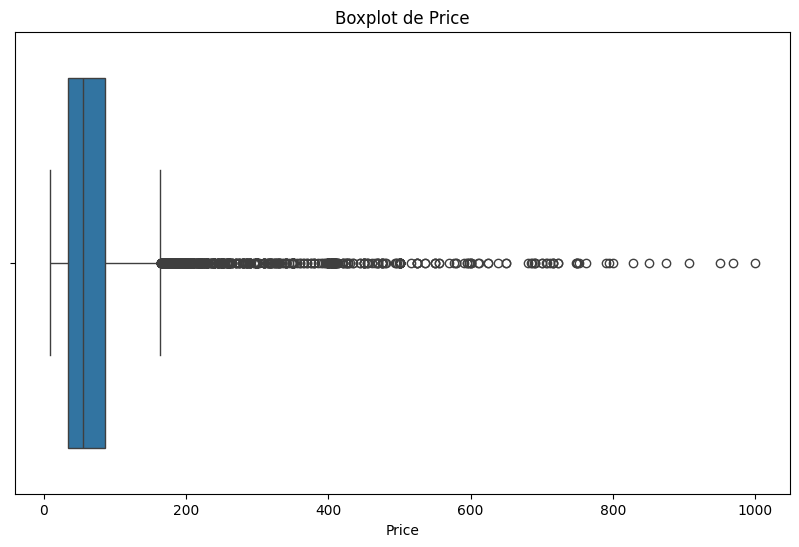

In [8]:
# b. Outliers (visualización con boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Price'])
plt.title('Boxplot de Price')
plt.show()

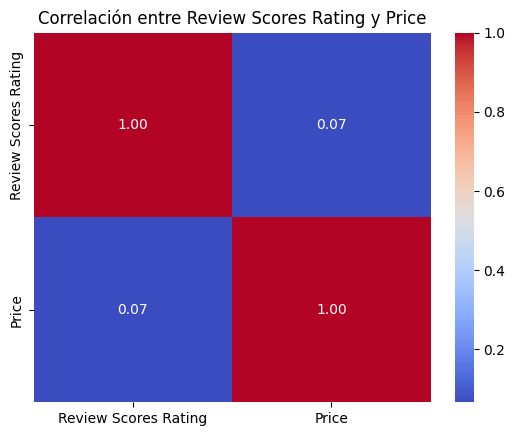

In [11]:
# Convertir la columna 'Price' a tipo de dato numérico
train_data['Price'] = pd.to_numeric(train_data['Price'], errors='coerce')
# Encuentra las filas donde el precio es NaN o no es un número
invalid_price_rows = df[df['Price'].isnull() | ~df['Price'].astype(str).str.isnumeric()]
# Elimina las filas con precios no válidos
data_cleaned = df.drop(invalid_price_rows.index)
# Eliminar filas con valores vacíos en 'Review Scores Rating'
data_cleaned = df.dropna(subset=['Review Scores Rating'])

# Calcular la correlación entre 'Review Scores Rating' y 'Price'
correlation = data_cleaned[['Review Scores Rating', 'Price']].corr()

# Visualizar la correlación
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre Review Scores Rating y Price')
plt.show()

Una correlación de 0.07 indica una relación positiva débil. Esto significa que hay una tendencia positiva, pero es muy tenue. En términos prácticos, no se puede establecer una fuerte conexión entre 'Review Scores Rating' y 'Price' basándose únicamente en esta correlación.

In [ ]:

# Por ejemplo, eliminar la columna 'ID' si no es relevante.
df = df.drop(columns=['ID'])


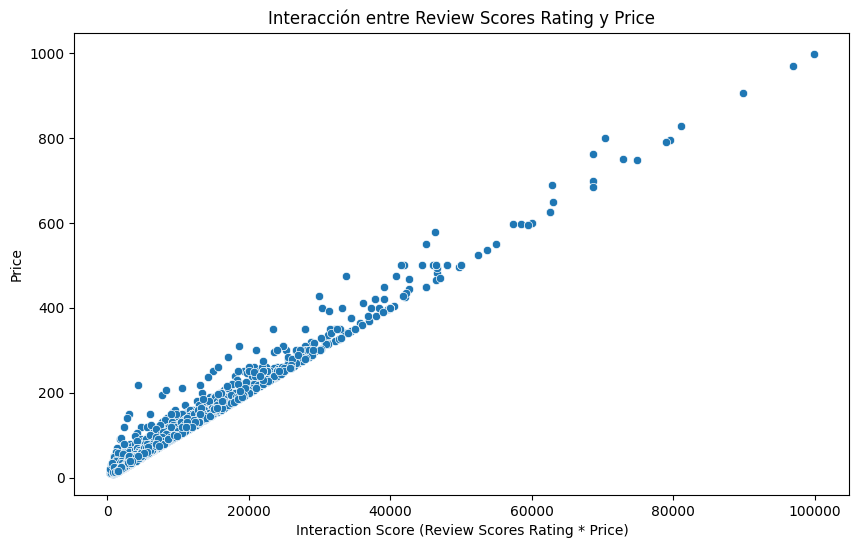

In [24]:
# b. Generación de variables
# Crear una nueva columna que representa la interacción entre 'Review Scores Rating' y 'Price'
df['Interaction_Score_Price'] = df['Review Scores Rating'] * df['Price']

# Visualizar la relación entre la nueva columna y 'Price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Interaction_Score_Price'], y=df['Price'])
plt.title('Interacción entre Review Scores Rating y Price')
plt.xlabel('Interaction Score (Review Scores Rating * Price)')
plt.ylabel('Price')
plt.show()

In [62]:

features = train_data.select_dtypes(include=['float64', 'int64'])  # Seleccionar solo variables numéricas
target = train_data['Price']
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)
# Crear un nuevo DataFrame con las columnas imputadas
features_imputed_df = pd.DataFrame(features_imputed, columns=features.columns)

# Seleccionar solo variables numéricas
features = train_data.select_dtypes(include=['float64', 'int64'])
target = train_data['Price']
# Eliminar filas con valores nulos en la variable objetivo
train_data = train_data.dropna(subset=['Price'])
# Imputar valores nulos en las variables predictoras
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)
# Crear un nuevo DataFrame con las columnas imputadas
features_imputed_df = pd.DataFrame(features_imputed, columns=features.columns)

# Entrenar el modelo Random Forest
model = RandomForestRegressor()
model.fit(features_imputed_df, train_data['Price'])

RandomForestRegressor()

In [63]:
model_lasso = Lasso()

In [74]:
# Eliminar filas duplicadas
df = df.drop_duplicates()

# Eliminar valores vacíos, nulos o letras de la columna 'Price'
df = df[pd.to_numeric(df['Price'], errors='coerce').notnull()]
df['Price'] = df['Price'].astype(float)

# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = df.drop(columns=['Price', 'Interaction_Score_Price'])
y = df['Price']

# Regresión Lineal
linear_reg_model = LinearRegression()
linear_reg_scores = cross_val_score(linear_reg_model, X, y, scoring='neg_mean_squared_error', cv=5)
linear_reg_rmse = (-linear_reg_scores.mean()) ** 0.5
print(f'Regresión Lineal - RMSE: {linear_reg_rmse}')

Regresión Lineal - RMSE: 19.591463206840526


In [76]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# Model Lasso
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)
lasso_preds = lasso_model.predict(X_test)
lasso_rmse = mean_squared_error(y_test, lasso_preds, squared=False)
print(f'Modelo Lasso - RMSE: {lasso_rmse}')

Modelo Lasso - RMSE: 20.706721741780566


C:\Users\Gonzalo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.690e+01, tolerance: 1.064e+01
  model = cd_fast.enet_coordinate_descent(


In [82]:
# Configurar la validación cruzada con KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)


# 5 Conclusión

In [ ]:
# La comparación entre la regresión lineal y el modelo Lasso revela que, aunque ambos presentan resultados similares en términos de RMSE durante la validación cruzada, la interpretabilidad del modelo lineal simple podría ser preferida en este contexto. La penalización adicional de Lasso no parece aportar beneficios significativos en este conjunto de datos específico.